In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
dl.load_data()
df= pd.DataFrame(dl.mtx)
df.sum().value_counts()

897      211
958      209
942      207
909      203
950      202
        ... 
3491       1
1872       1
8381       1
22693      1
7069       1
Length: 7364, dtype: int64

In [ ]:
dl.mtx.T[:,:1000].shape

In [3]:
model = np.load(sample_out+'_altnmf.npz')

In [ ]:
#   ColVec Ysum = Y.colwise().sum().transpose(); // n x 1
#     Mat R = (Y.transpose() * log_X).array().colwise() / Ysum.array();

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(model['beta_log'])

In [ ]:
# t1 = pd.DataFrame(np.dot(df, model['beta_log']))
t1 = pd.DataFrame(np.dot(df, scaled))

In [ ]:
ysum = np.array(df.T.sum()).reshape(1000 ,1)

In [ ]:
t2 = t1/ysum

In [ ]:
beta = nmf.beta
theta = reg.theta
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(theta)
df_theta.index = dl.rows

In [ ]:
df_corr = pd.DataFrame(model['corr'])
df_corr

In [ ]:
df_corr.isna().sum()

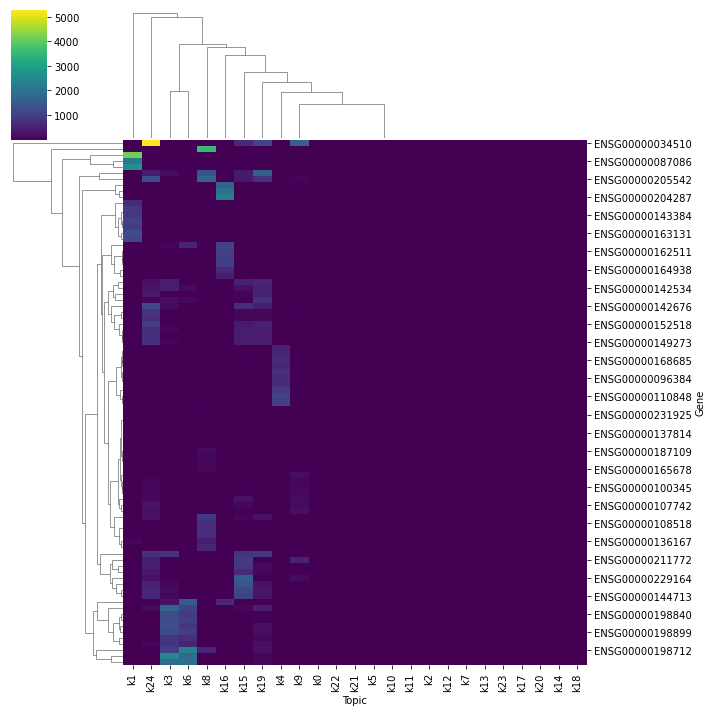

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [ ]:
model['theta']

In [ ]:
df_theta = t2

In [5]:
import umap
df_theta = pd.DataFrame(model['corr'])
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,"0_Tcell,CD4,naive[activated]",4,11.644117,-3.919565
1,"1_Tcell,CD4,naive[activated]",4,12.919374,-4.783111
2,"2_Tcell,CD4,naive[activated]",4,11.091277,-6.084971
3,"3_Tcell,CD4,naive[activated]",4,9.432678,-4.865322
4,"4_Tcell,CD4,naive[activated]",4,8.850451,-7.181763
...,...,...,...,...
14995,"995_Tcell,CD8,naive[activated]",4,-0.581492,-4.318170
14996,"996_Tcell,CD8,naive[activated]",4,-2.112039,-7.299943
14997,"997_Tcell,CD8,naive[activated]",4,-2.148324,-3.418716
14998,"998_Tcell,CD8,naive[activated]",4,-1.359757,-6.686238


Text(0, 0.5, 'UMAP2')

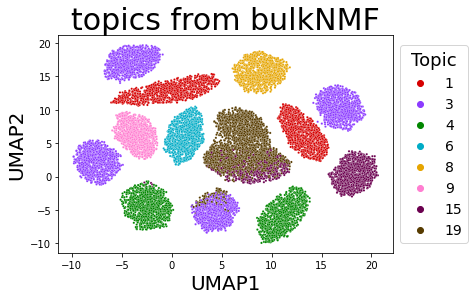

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

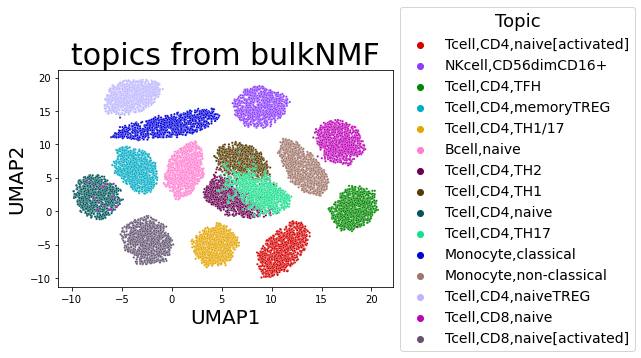

In [7]:
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [8]:
dl.mtx.shape

(15000, 57773)

In [9]:
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
df_dice = pd.read_csv(bulk_data,compression='zip')

# remove non naive T cells
# df_dice = df_dice[['gene', 
# 'Monocyte, classical',
# 'Monocyte, non-classical',
# 'NK cell, CD56dim CD16+',
# 'B cell, naive', 
# 'T cell, CD8, naive',
# 'T cell, CD4, naive',
# 'T cell, CD8, naive [activated]',
# 'T cell, CD4, naive [activated]',
# 'T cell, CD4, memory TREG', 
# 'T cell, CD4, TH1/17',
# ]]
df_dice = df_dice.set_index('gene').T

Text(218.45454545454544, 0.5, 'bulk')

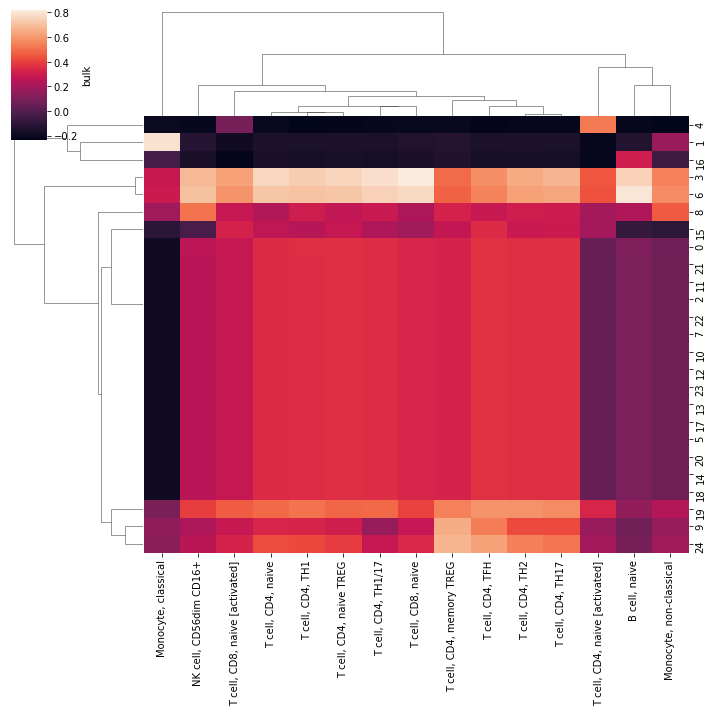

In [10]:
sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in df_beta.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(df_beta.loc[i,sel_top_genes],df_dice.loc[j,sel_top_genes])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = df_beta.index
df_corr.columns = df_dice.index
sns.clustermap(df_corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [11]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match


cell                                          \
topic_bulk                      1       3       4       6       8       9    
cell_type                                                                    
Bcell,naive                    0.0     0.0     0.0  1000.0     0.0     0.0   
Monocyte,classical          1000.0     0.0     0.0     0.0     0.0     0.0   
Monocyte,non-classical      1000.0     0.0     0.0     0.0     0.0     0.0   
NKcell,CD56dimCD16+            0.0     0.0     0.0     0.0  1000.0     0.0   
Tcell,CD4,TFH                  0.0     0.0     0.0     0.0     0.0     0.0   
Tcell,CD4,TH1                  0.0     0.0     0.0     0.0     0.0     0.0   
Tcell,CD4,TH1/17               0.0   865.0     0.0     0.0     0.0     0.0   
Tcell,CD4,TH17                 0.0     0.0     0.0     0.0     0.0     0.0   
Tcell,CD4,TH2                  0.0     0.0     0.0     0.0     0.0     0.0   
Tcell,CD4,memoryTREG           0.0     0.0     0.0     0.0     0.0  1000.0   
Tcell,CD4,naive                0.0  1000.0     0.0     0.0     0.0     0.0   
Tcell,CD4,naiveTREG            0.0  1000.0     0.0     0.0     0.0     0.0   
Tcell,CD4,naive[activated]     0.0     0.0  1000.0     0.0     0.0     0.0   
Tcell,CD8,naive                0.0  1000.0     0.0     0.0     0.0     0.0   
Tcell,CD8,naive[activated]     0.0     0.0   994.0     0.0     0.0     0.0   

                                           
topic_bulk                      15     19  
cell_type                                  
Bcell,naive                    0.0    0.0  
Monocyte,classical             0.0    0.0  
Monocyte,non-classical         0.0    0.0  
NKcell,CD56dimCD16+            0.0    0.0  
Tcell,CD4,TFH               1000.0    0.0  
Tcell,CD4,TH1                  1.0  999.0  
Tcell,CD4,TH1/17               0.0  135.0  
Tcell,CD4,TH17               241.0  759.0  
Tcell,CD4,TH2                236.0  764.0  
Tcell,CD4,memoryTREG           0.0    0.0  
Tcell,CD4,naive                0.0    0.0  
Tcell,CD4,naiveTREG            0.0    0.0  
Tcell,CD4,naive[activated]     0.0    0.0  
Tcell,CD8,naive                0.0    0.0  
Tcell,CD8,naive[activated]     6.0    0.0

In [ ]:
sns.clustermap(df_match)

In [12]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.7966645427845829